# Análisis discriminante lineal (LDA)

LDA es una técnica de reducción de dimensionalidad que se usa comúnmente para tareas de clasificación. El objetivo de LDA es proyectar un conjunto de datos en un espacio de dimensiones inferiores para que las clases del conjunto de datos sean más fácilmente separables. Esto se hace encontrando una combinación lineal de características que maximice la separación entre las clases.

## Intuición detrás del Análisis Discriminante Lineal (LDA)

De manera intuitiva, LDA intenta encontrar un conjunto de ejes (dimensiones) que sean más efectivos para separar las diferentes clases en un conjunto de datos. Estos ejes se denominan “ejes discriminantes” (proyecciones) porque están diseñados específicamente para discriminar entre las diferentes clases. El objetivo de LDA es encontrar las direcciones en los datos que harán más fácil trazar un límite de decisión que separe las diferentes clases. En otras palabras, LDA tiene como objetivo encontrar un nuevo subespacio de características que conserve la mayor parte de la información discriminatoria de clases^1

Lo que es importante recordar son dos conceptos al elegir los ejes:

- LDA maximiza la distancia entre las “medias” de clases
- LDA minimiza la variación dentro de las clases.

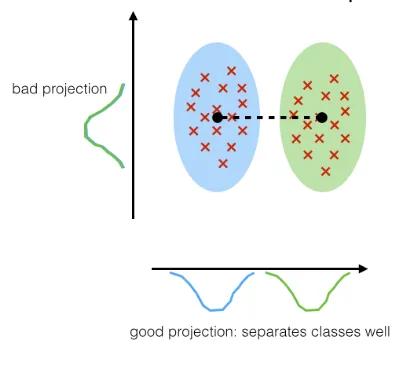

Durante el entrenamiento del modelo LDA, se calculan las propiedades estadísticas (es decir, matriz de media y covarianza) de cada clase. Las propiedades estadísticas se estiman sobre la base de los siguientes supuestos sobre los datos:

- Los datos se distribuyen normalmente, de modo que cada variable tiene forma de campana cuando se traza.
- Cada atributo tiene la misma varianza y los valores de cada variable varían alrededor de la media en la misma cantidad en promedio.

Para hacer una predicción, LDA estima la probabilidad de que un nuevo conjunto de entradas pertenezca a cada clase. La clase de salida es la que tiene mayor probabilidad.

# Ejemplo de clasificación 

El conjunto de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.

Contiene solo variables de entrada numéricas que son el resultado de una transformación PCA. Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales ni más información general sobre los datos. Las características V1, V2, … V28 son los principales componentes obtenidos con PCA, las únicas características que no han sido transformadas con PCA son 'Tiempo' y 'Cantidad'. La característica 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La función 'Cantidad' es la cantidad de la transacción, esta función se puede utilizar para el aprendizaje sensible a los costos dependiente del ejemplo. Feature 'Class' es la variable de respuesta y toma valor 1 en caso de fraude y 0 en caso contrario.

## Importar librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy

from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
#Metricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Funciones auxiliares

In [2]:
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [3]:
# Transormador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [4]:
# Transformador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

In [5]:
dataset = pd.read_csv("creditcard.csv")

## División del conjunto de datos

In [6]:
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size=validation_size, 
                                                   stratify=dataset["Class"],
                                                   random_state=seed)

## Preparación del conjunto de datos¶

In [7]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [8]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X)

DataFramePreparer()

## Escalado del conjunto de datos

In [9]:
# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)

In [10]:
# Transformamos el subconjunto de datos de validacion
X_test_prep = data_preparer.transform(X_test)

## Modelo Análisis discriminante lineal

In [11]:
model_LDA = LinearDiscriminantAnalysis()
X_lda=model_LDA.fit(X_train_prep, Y_train)

In [12]:
# Accuracy de test del modelo 

Y_pred = model_LDA.predict(X=X_test_prep)
print(accuracy_score(Y_test, Y_pred))

0.999420666409185
